In [1]:
import ee
import os
import re
import csv
import glob
import geemap
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
import geopandas as gpd
import matplotlib.colors
from scipy.stats import norm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get today's date and create a directory name in the format "yyyyMMdd"
today = datetime.date.today()
dir_in = today.strftime("%Y%m%d")
out_dir = 'G:/001Project/Output/Figures/Methods/' + dir_in + '/'

# Create the output directory if it doesn't exist
# os.makedirs(out_dir, exist_ok=True)

# Check if the directory already exists, and if not, create it
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## For a single Year

In [3]:
# Read the data into a DataFrame
file_path = "G:/001Project/Output/Sheets/cleaned_Results/combined/Combined_PRISM_2021.csv"
df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Prepare the list of columns
columns = ["DISALEXI", "EEMETRIC", "GEESEBAL", "PTJPL", "SIMS", "SSEBOP",
           "DAYMET", "gridMET", "IMERG", "NLDAS", "PRISM"]

# Create a 'YearMonth' column for grouping, formatted as "MM/YYYY"
df['YearMonth'] = df['Date'].dt.strftime('%m/%Y')

# Group by the 'YearMonth' and calculate the average
monthly_averages = df.groupby('YearMonth')[columns].mean().reset_index()

monthly_averages

,YearMonth,DISALEXI,EEMETRIC,GEESEBAL,PTJPL,SIMS,SSEBOP,DAYMET,gridMET,IMERG,NLDAS,PRISM
0,01/2021,17.924260,21.799041,11.205941,12.716088,18.316470,11.408767,18.623804,18.014600,20.265766,17.313276,17.953121
1,02/2021,30.063915,20.338669,15.753453,17.121701,18.712592,10.301174,9.977910,9.358954,14.738049,9.147181,9.144740
2,03/2021,42.908880,38.511062,39.464078,43.752430,55.474402,23.357802,90.279693,90.406382,111.243775,85.337741,89.802336
3,04/2021,58.427208,48.526071,48.170105,55.124527,60.362604,40.505109,29.237337,29.080328,31.944485,26.913867,28.766670
4,05/2021,71.808569,67.737794,66.933802,84.294663,104.149237,56.557861,118.330306,115.456718,114.005676,112.254898,111.554113
5,06/2021,103.068437,111.342680,91.018103,101.978105,119.066324,101.780332,59.298995,60.131215,63.039248,55.767805,59.692873
6,07/2021,133.321553,143.258715,126.776711,135.709504,149.698439,137.816687,64.582146,69.195947,73.171745,64.703156,66.979914
7,08/2021,115.288030,152.758053,107.909286,117.917524,147.582290,149.085329,59.179321,62.405598,68.004289,62.415464,65.539067
8,09/2021,75.354978,111.554164,65.866024,75.416832,102.191668,97.835019,45.886574,47.434222,42.877598,43.124997,43.714106
9,10/2021,36.914664,63.416231,41.768211,57.088522,61.600191,47.757892,39.920160,39.976987,NaN,37.783538,42.006123


## For all the years

In [5]:
# Create a list of the file paths for the years 2016 - 2021
folder_path = "G:/001Project/Output/Sheets/cleaned_Results/combined"
file_names = [f"Combined_PRISM_{year}.csv" for year in range(2016, 2022)]
file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]

# Define a function that processes a file and returns the processed DataFrame
def process_file(file_path):
    # Read the data into a DataFrame
    df = pd.read_csv(file_path)

    # Convert the 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # List of columns to calculate the average
    columns = ["DISALEXI", "EEMETRIC", "GEESEBAL", "PTJPL", "SIMS", "SSEBOP", 
                          "DAYMET", "gridMET", "IMERG", "NLDAS", "PRISM"]

    # Create a 'YearMonth' column for grouping, formatted as "MM/YYYY"
    df['YearMonth'] = df['Date'].dt.strftime('%m/%Y')

    # Group by 'YearMonth' and calculate the average
    monthly_averages = df.groupby('YearMonth')[columns].mean().reset_index()

    return monthly_averages

# Process all years and concatenate the results
combined_data = pd.concat([process_file(file) for file in file_paths])

# Resetting the index of the final DataFrame
combined_data.reset_index(drop=True, inplace=True)

combined_data.to_csv("G:/001Project/Output/Sheets/cleaned_Results/combined/ET_P_monthly_averages.csv")

## Visualise ET and P Evolution

In [5]:
# List the columns
Evapotranspiration = ["DISALEXI", "EEMETRIC", "GEESEBAL", "PTJPL", "SIMS", "SSEBOP"]
Precipitation = ["DAYMET", "gridMET", "IMERG", "NLDAS", "PRISM"]

# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(30, 9), sharey=True)

# Adjust space between the plots
plt.subplots_adjust(wspace=0.02)

# Converting 'YearMonth' back to datetime for proper plotting
combined_data['YearMonth'] = pd.to_datetime(combined_data['YearMonth'], format='%m/%Y')
combined_data.sort_values('YearMonth', inplace=True)

# Plotting the first set of columns
for column in Evapotranspiration:
    axs[0].plot(combined_data['YearMonth'], combined_data[column], marker='', label=column, linestyle='-')
    axs[0].set_title('Evapotranspiration', fontsize=15, fontweight='bold')
    axs[0].set_ylabel('mm/month', fontsize=14, fontweight='bold')
    axs[0].set_xlabel('Time', fontsize=14, fontweight='bold')
    axs[0].legend(fontsize=12, ncol=2)

# Plotting the second set of columns
for column in Precipitation:
    axs[1].plot(combined_data['YearMonth'], combined_data[column], marker='', label=column, linestyle='--')
    axs[1].set_title('Precipitation', fontsize=15, fontweight='bold')
    #axs[1].set_ylabel('mm/month')
    axs[1].set_xlabel('Time', fontsize=14, fontweight='bold')
    axs[1].legend(fontsize=12)

#plt.savefig(out_dir + 'ET_P_HPA.png', dpi=300, bbox_inches='tight')
plt.tight_layout
plt.show()

Average Precipitation for 2019:
DAYMET     59.169274
gridMET    60.002921
IMERG      59.226572
NLDAS      55.786159
PRISM      59.392649
dtype: float64


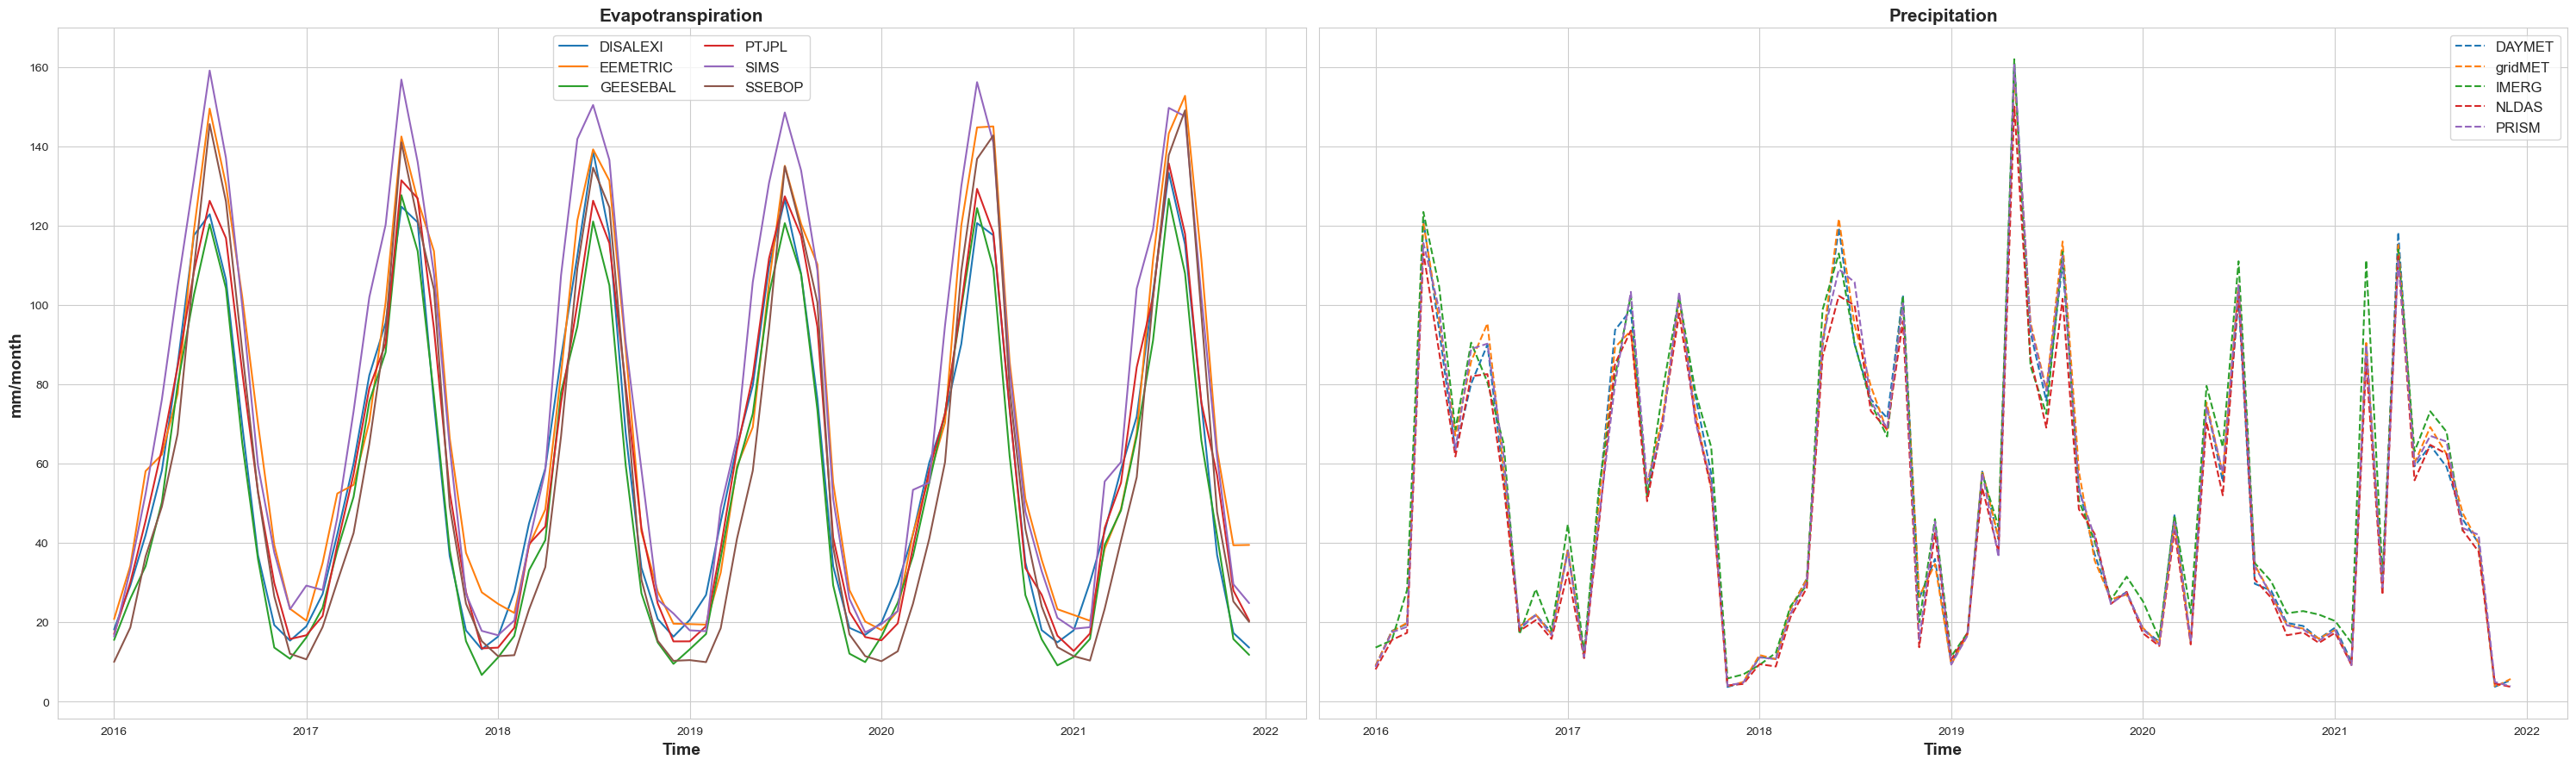

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# List the columns
Evapotranspiration = ["DISALEXI", "EEMETRIC", "GEESEBAL", "PTJPL", "SIMS", "SSEBOP"]
Precipitation = ["DAYMET", "gridMET", "IMERG", "NLDAS", "PRISM"]

# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(30, 9), sharey=True)

# Adjust space between the plots
plt.subplots_adjust(wspace=0.02)

# Converting 'YearMonth' back to datetime for proper plotting
combined_data['YearMonth'] = pd.to_datetime(combined_data['YearMonth'], format='%m/%Y')
combined_data.sort_values('YearMonth', inplace=True)

# Filter the data for the year 2019
data_2019 = combined_data[combined_data['YearMonth'].dt.year == 2019]

# Calculate the average precipitation for 2019
average_precipitation_2019 = data_2019[Precipitation].mean()

# Print the average precipitation for 2019
print("Average Precipitation for 2019:")
print(average_precipitation_2019)

# Plotting the first set of columns
for column in Evapotranspiration:
    axs[0].plot(combined_data['YearMonth'], combined_data[column], marker='', label=column, linestyle='-')
    axs[0].set_title('Evapotranspiration', fontsize=15, fontweight='bold')
    axs[0].set_ylabel('mm/month', fontsize=14, fontweight='bold')
    axs[0].set_xlabel('Time', fontsize=14, fontweight='bold')
    axs[0].legend(fontsize=12, ncol=2)

# Plotting the second set of columns
for column in Precipitation:
    axs[1].plot(combined_data['YearMonth'], combined_data[column], marker='', label=column, linestyle='--')
    axs[1].set_title('Precipitation', fontsize=15, fontweight='bold')
    axs[1].set_xlabel('Time', fontsize=14, fontweight='bold')
    axs[1].legend(fontsize=12)

#plt.savefig(out_dir + 'ET_P_HPA.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()